# PISA 2012 Data Exploration

## Introduction

PISA stands for the Programme for International Student Assessment. Every few years, since 1997, it has compared 15-year-old students from different countries based on their reading, math and science acumen with the goal of improving education policy. This report explores the data from 2012.

In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

In [2]:
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

/tmp/ipykernel_1972329/4715378.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Preliminary Wrangling

This data is 2.6 GiB. Loading in all of it would be inefficient—and unnecessary. Interesting columns can be IDed using the accompanying data dictionary, which lists the dataset's column names and a brief description.

In [3]:
df_dict = pd.read_csv(
    'pisadict2012.csv',
    encoding='latin-1',
    names=['Dataset Column Name', 'Description'],
    skiprows=1
)

In [4]:
df_dict

,Dataset Column Name,Description
0,CNT,Country code 3-character
1,SUBNATIO,Adjudicated sub-region code 7-digit code (3-di...
2,STRATUM,Stratum ID 7-character (cnt + region ID + orig...
3,OECD,OECD country
4,NC,National Centre 6-digit Code
...,...,...
630,W_FSTR80,FINAL STUDENT REPLICATE BRR-FAY WEIGHT80
631,WVARSTRR,RANDOMIZED FINAL VARIANCE STRATUM (1-80)
632,VAR_UNIT,RANDOMLY ASSIGNED VARIANCE UNIT
633,SENWGT_STU,Senate weight - sum of weight within the count...


🎗 `df_dict` lists the dataset column names. Thus, its row count reflects the dataset's *column* count (635).

In [5]:
# To find the dataset's row count, we will need to read the dataset itself, but
# we won't need to store it in memory.
with open('pisa2012.csv', 'r', encoding='latin-1') as f:
    for index, _ in enumerate(f):
        pass
print(f'The dataset\'s row count: {index}')

The dataset's row count: 485490


> 💡 Using command-line utilities is faster.
> 
> ```shell
> !wc --lines pisa2012.csv | awk '{print "The datasetʼs row count: " $1 - 1}'
> ```

### What is the structure of your dataset?

The PISA 2012 dataset includes 485,490 students and 635 features!

### What is/are the main feature(s) of interest in your dataset?

The features of interest are those pertaining to math. I live in the United States, a highly developed country that famously underperforms at math. Conversely, our neighbor Canada excels at math. Yet the two countries are otherwise quite similar.

I am mainly interested in features regarding math performance: namely, why some have it and other don't, and how those who don't have it can unlock it.

In [6]:
df_dict_math = df_dict.query('`Description`.str.contains("Math")')

In [7]:
df_dict_math.shape[0]

120

In [8]:
# Due to the length of `df_dict_math`, we are better off exporting it and
# persusing it externally. Jupyter Lab's CSVTable is good for this.
df_dict_math.to_csv('pisadict2012_math.csv')

There are 120 features related to math. They are grouped as follows:

- Interest
- Subjective Norms
- Self-Efficacy
- Anxiety & Self-Concept
- Attributions to Failure
- Work Ethic
- Intentions
- Behavior
- Experience with Pure & Applied Math Tasks
- Familiarity with Math Concepts
- Class Period
- OTL (Opportunity to Learn)
- Math Teaching
- Math Lessons

So what gives Canadian students an edge over their American counterparts? While it could be any of the above, one group of features stands out: Intentions. 

According to [the theory of planned behavior](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/SB/BehavioralChangeTheories/BehavioralChangeTheories3.html) (TPB), one's intentions are the proximate cause of his or her actions. Accidents aside, actions are certainly preceded by intentions.

This group is comprised of five variables (`ST48Q01` to `ST48Q05`), as well as an aggregate score (`MATINTFC`).

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6b/Theory_of_planned_behavior.png" alt="Diagram showing causal chain from subjective norms through intentions on to behavior" width="640" height="380">

<span style="font-size:80%;">“Theory of planned behavior”, by Robert Orzanna, licensed under <a href="https://creativecommons.org/licenses/by-sa/4.0/deed.en">CC BY 4.0</a></span>

Per the TPB, three factors affect intentions: subjective norms, attitude, and *perceived behavioral control*.* Conveniently, 'Subjective Norms' already exists as a category of features. We will want to look at that. As for attitude and perceived behavioral control, we can use the 'Self-Concept' and 'Self-Efficacy' groups, respectively. For our purposes, the aggregate scores should suffice.

Also, we will definitely need the countries column ('CNT') in order to tell apart the Canadian and American students.

*Perceived behavioral control is defined as a person's perceived ease or difficulty of performing some specific behavior, in this case math.

In [9]:
# Select the columns to use. When in doubt, cast a wide net.
cols = df_dict_math['Dataset Column Name']

In [10]:
# Add the countries column.
cols = pd.concat([pd.Series(['CNT']), cols])

In [11]:
# Import the CSV using the experimental, new pyarrow engine—it's much faster!
df = pd.read_csv(
    'pisa2012.csv',
    encoding='latin-1',
    usecols=cols,
    engine='pyarrow'
)

In [12]:
df = df.query('CNT == "United States of America" or CNT == "Canada"')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26522 entries, 74470 to 480530
Columns: 121 entries, CNT to ANCSUBNORM
dtypes: float64(29), object(92)
memory usage: 24.7+ MB


Most of the columns are object-type, which makes sense. Per the data dictionary, most of the features are survey questions. The rest of the columns are float-type.

In [14]:
df.head()

,CNT,ST29Q01,ST29Q03,ST29Q04,ST29Q06,ST35Q01,ST35Q02,ST35Q03,ST35Q04,ST35Q05,ST35Q06,ST37Q01,ST37Q02,ST37Q03,ST37Q04,ST37Q05,ST37Q06,ST37Q07,ST37Q08,ST42Q01,ST42Q02,ST42Q03,ST42Q04,ST42Q05,ST42Q06,ST42Q07,ST42Q08,ST42Q09,ST42Q10,ST44Q01,ST46Q01,ST46Q02,ST46Q03,ST46Q04,ST46Q05,ST46Q06,ST46Q07,ST46Q08,ST46Q09,ST48Q01,ST48Q02,ST48Q03,ST48Q04,ST48Q05,ST49Q01,ST49Q02,ST49Q03,ST49Q04,ST49Q05,ST49Q06,ST49Q07,ST49Q09,ST61Q01,ST61Q02,ST61Q03,ST61Q04,ST61Q05,ST61Q06,ST61Q07,ST61Q08,ST61Q09,ST62Q01,ST62Q02,ST62Q03,ST62Q06,ST62Q07,ST62Q08,ST62Q09,ST62Q10,ST62Q12,ST62Q15,ST62Q16,ST62Q17,ST62Q19,ST69Q02,ST70Q02,ST73Q01,ST74Q01,ST75Q01,ST75Q02,ST76Q01,ST76Q02,ST77Q01,ST77Q02,ST77Q04,ST77Q05,ST77Q06,IC11Q01,IC11Q02,IC11Q03,IC11Q04,IC11Q05,IC11Q06,IC11Q07,ANXMAT,CLSMAN,COGACT,EXAPPLM,EXPUREM,FAILMAT,FAMCON,FAMCONC,INSTMOT,INTMAT,MATBEH,MATHEFF,MATINTFC,MATWKETH,MMINS,MTSUP,SCMAT,SUBNORM,USEMATH,ANCCLSMAN,ANCCOGACT,ANCINSTMOT,ANCINTMAT,ANCMATWKETH,ANCMTSUP,ANCSCMAT,ANCSUBNORM
74470,Canada,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Agree,Disagree,Disagree,Agree,Strongly disagree,Agree,Strongly disagree,Disagree,Agree,Disagree,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Frequently,Sometimes,Frequently,Never,Frequently,Never,Frequently,Never,Frequently,"Know it well, understand the concept",Never heard of it,Heard of it a few times,"Know it well, understand the concept","Know it well, understand the concept",Never heard of it,"Know it well, understand the concept","Know it well, understand the concept","Know it well, understand the concept",Never heard of it,"Know it well, understand the concept",Never heard of it,"Know it well, understand the concept",65.0,5.0,Rarely,Frequently,Rarely,Rarely,Rarely,Never,Every Lesson,Every Lesson,Every Lesson,Every Lesson,Every Lesson,NA,NA,NA,NA,NA,NA,NA,-0.47,0.7640,1.5176,-0.2531,0.7955,NaN,0.2052,0.85,NaN,NaN,NaN,NaN,NaN,NaN,325.0,1.8433,0.18,NaN,NaN,0.484,0.870,NaN,NaN,NaN,0.8270,0.3971,NaN
74471,Canada,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Agree,Agree,Agree,Agree,Agree,Agree,Disagree,Agree,Disagree,Agree,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Never,Never,Never,Never,Sometimes,Never,Sometimes,Never,Sometimes,Heard of it often,Heard of it often,Heard of it a few times,Heard of it often,Heard of it once or twice,Heard of it often,Heard of it often,Heard of it once or twice,Heard of it often,Never heard of it,Never heard of it,Never heard of it,Heard of it often,65.0,5.0,Sometimes,Frequently,Sometimes,Sometimes,Rarely,Rarely,Every Lesson,Every Lesson,Every Lesson,Most Lessons,Most Lessons,NA,NA,NA,NA,NA,NA,NA,0.79,-0.4499,0.1202,-2.9868,-0.6635,NaN,-0.3163,-0.33,NaN,NaN,NaN,NaN,NaN,NaN,325.0,-0.2395,-0.06,NaN,NaN,-0.237,0.085,NaN,NaN,NaN,-0.1687,-0.0807,NaN
74472,Canada,Disagree,NA,Strongly disagree,Disagree,Agree,Agree,Disagree,Strongly agree,Agree,Agree,Not very confident,Not very confident,Not at all confident,Confident,Not very confident,Confident,Confident,Not very confident,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Likely,Disagree,Disagree,Disagree,Disagree,Agree,Disagree,Agree,Strongly disagree,Agree,Courses after school Math,Major in college Math,Study harder Test Language,Maximum classes Science,Pursuing a career Science,Never or rarely,Sometimes,Never or rarely,Never or rarely,Never or rarely,Never or rarely,Never or rarely,Never or rarely,Never,Rarely,Rarely,Sometimes,Rarely,Sometimes,Sometimes,Rarely,Never,Never heard of it,Never heard of it,Heard of it once or twice,Heard of it a few times,Heard of it once or twice,Heard of it once or twice,Heard of it once or twice,Heard of it once or twice,Heard of it a few times,Heard of it once or twice,Heard of it often,Heard of it a few times,Heard of it often,60.0,5.0,Rarely,Rarely,Sometimes,Rarely,Sometimes,Rarely,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NaN,NaN,NaN,-0.4371,-1.5748,0.3889,-0.7159,-1.66,0.05,-0.79,-1.0226,-1.06,-0.2514,-0.8805,300.0,NaN,NaN,0.6602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

The missing values in the object-type columns are marked with 'NA' _strings_. Pyarrow seems to have failed at converting the 'NA' values into null values. Oops!

In [15]:
df = df.replace('NA', pd.NA)
df.head(1)

,CNT,ST29Q01,ST29Q03,ST29Q04,ST29Q06,ST35Q01,ST35Q02,ST35Q03,ST35Q04,ST35Q05,ST35Q06,ST37Q01,ST37Q02,ST37Q03,ST37Q04,ST37Q05,ST37Q06,ST37Q07,ST37Q08,ST42Q01,ST42Q02,ST42Q03,ST42Q04,ST42Q05,ST42Q06,ST42Q07,ST42Q08,ST42Q09,ST42Q10,ST44Q01,ST46Q01,ST46Q02,ST46Q03,ST46Q04,ST46Q05,ST46Q06,ST46Q07,ST46Q08,ST46Q09,ST48Q01,ST48Q02,ST48Q03,ST48Q04,ST48Q05,ST49Q01,ST49Q02,ST49Q03,ST49Q04,ST49Q05,ST49Q06,ST49Q07,ST49Q09,ST61Q01,ST61Q02,ST61Q03,ST61Q04,ST61Q05,ST61Q06,ST61Q07,ST61Q08,ST61Q09,ST62Q01,ST62Q02,ST62Q03,ST62Q06,ST62Q07,ST62Q08,ST62Q09,ST62Q10,ST62Q12,ST62Q15,ST62Q16,ST62Q17,ST62Q19,ST69Q02,ST70Q02,ST73Q01,ST74Q01,ST75Q01,ST75Q02,ST76Q01,ST76Q02,ST77Q01,ST77Q02,ST77Q04,ST77Q05,ST77Q06,IC11Q01,IC11Q02,IC11Q03,IC11Q04,IC11Q05,IC11Q06,IC11Q07,ANXMAT,CLSMAN,COGACT,EXAPPLM,EXPUREM,FAILMAT,FAMCON,FAMCONC,INSTMOT,INTMAT,MATBEH,MATHEFF,MATINTFC,MATWKETH,MMINS,MTSUP,SCMAT,SUBNORM,USEMATH,ANCCLSMAN,ANCCOGACT,ANCINSTMOT,ANCINTMAT,ANCMATWKETH,ANCMTSUP,ANCSCMAT,ANCSUBNORM
74470,Canada,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Agree,Disagree,Disagree,Agree,Strongly disagree,Agree,Strongly disagree,Disagree,Agree,Disagree,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Frequently,Sometimes,Frequently,Never,Frequently,Never,Frequently,Never,Frequently,"Know it well, understand the concept",Never heard of it,Heard of it a few times,"Know it well, understand the concept","Know it well, understand the concept",Never heard of it,"Know it well, understand the concept","Know it well, understand the concept","Know it well, understand the concept",Never heard of it,"Know it well, understand the concept",Never heard of it,"Know it well, understand the concept",65.0,5.0,Rarely,Frequently,Rarely,Rarely,Rarely,Never,Every Lesson,Every Lesson,Every Lesson,Every Lesson,Every Lesson,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,-0.47,0.764,1.5176,-0.2531,0.7955,NaN,0.2052,0.85,NaN,NaN,NaN,NaN,NaN,NaN,325.0,1.8433,0.18,NaN,NaN,0.484,0.87,NaN,NaN,NaN,0.827,0.3971,NaN


In [16]:
# If we deal with the nulls by dropping any row that contains a null value—across
# 120 columns—there won't be any rows left! We'll have to take a more measured
# approach, dealing with them as we go along.
df.dropna()

,CNT,ST29Q01,ST29Q03,ST29Q04,ST29Q06,ST35Q01,ST35Q02,ST35Q03,ST35Q04,ST35Q05,ST35Q06,ST37Q01,ST37Q02,ST37Q03,ST37Q04,ST37Q05,ST37Q06,ST37Q07,ST37Q08,ST42Q01,ST42Q02,ST42Q03,ST42Q04,ST42Q05,ST42Q06,ST42Q07,ST42Q08,ST42Q09,ST42Q10,ST44Q01,ST46Q01,ST46Q02,ST46Q03,ST46Q04,ST46Q05,ST46Q06,ST46Q07,ST46Q08,ST46Q09,ST48Q01,ST48Q02,ST48Q03,ST48Q04,ST48Q05,ST49Q01,ST49Q02,ST49Q03,ST49Q04,ST49Q05,ST49Q06,ST49Q07,ST49Q09,ST61Q01,ST61Q02,ST61Q03,ST61Q04,ST61Q05,ST61Q06,ST61Q07,ST61Q08,ST61Q09,ST62Q01,ST62Q02,ST62Q03,ST62Q06,ST62Q07,ST62Q08,ST62Q09,ST62Q10,ST62Q12,ST62Q15,ST62Q16,ST62Q17,ST62Q19,ST69Q02,ST70Q02,ST73Q01,ST74Q01,ST75Q01,ST75Q02,ST76Q01,ST76Q02,ST77Q01,ST77Q02,ST77Q04,ST77Q05,ST77Q06,IC11Q01,IC11Q02,IC11Q03,IC11Q04,IC11Q05,IC11Q06,IC11Q07,ANXMAT,CLSMAN,COGACT,EXAPPLM,EXPUREM,FAILMAT,FAMCON,FAMCONC,INSTMOT,INTMAT,MATBEH,MATHEFF,MATINTFC,MATWKETH,MMINS,MTSUP,SCMAT,SUBNORM,USEMATH,ANCCLSMAN,ANCCOGACT,ANCINSTMOT,ANCINTMAT,ANCMATWKETH,ANCMTSUP,ANCSCMAT,ANCSUBNORM


## Preliminary Exploration: Intention Variables

Note: Separate Univariate, Bivariate, and Multivariate Exploration sections are coming up.

In [17]:
df_us = df.query('CNT == "United States of America"')
df_ca = df.query('CNT == "Canada"')

In [18]:
blue = sns.color_palette()[0]
green = sns.color_palette()[1]
red = sns.color_palette()[2]

In [19]:
df.ST48Q02.sort_values().value_counts()

ST48Q02
Major in college Science    9850
Major in college Math       6327
Name: count, dtype: int64

In [20]:
def pie(df_col, colors):
    '''Plot a pretty pie.'''
    x = df_col.value_counts()
    labels = df_col.value_counts().index.sort_values()
    
    plt.pie(
        x,
        labels=labels,
        colors=colors,
        autopct='%.0f',
        startangle=90,
        counterclock=False,
        labeldistance=None,
    )

In [21]:
def pie_fig(ca_col, us_col, colors, comps, title):
    '''Plot two pretty pies to easily compare CA & US.'''
    fig = plt.figure()
    
    ax1 = fig.add_subplot(1, 2, 1)
    l1 = pie(ca_col, colors)
    plt.title('Canada')
    ax2 = fig.add_subplot(1, 2, 2)
    l2 = pie(us_col, colors)
    plt.title('United States of America')
    
    labels=comps

    fig.legend([l1, l2], labels=labels, bbox_to_anchor=(1, .94))
    fig.suptitle(title, x=.18, y=.9, size=14);

### Are American students just focused on other subjects?

#### Language arts, perhaps?

/tmp/ipykernel_1972329/1569874537.py:14: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, bbox_to_anchor=(1, .94))


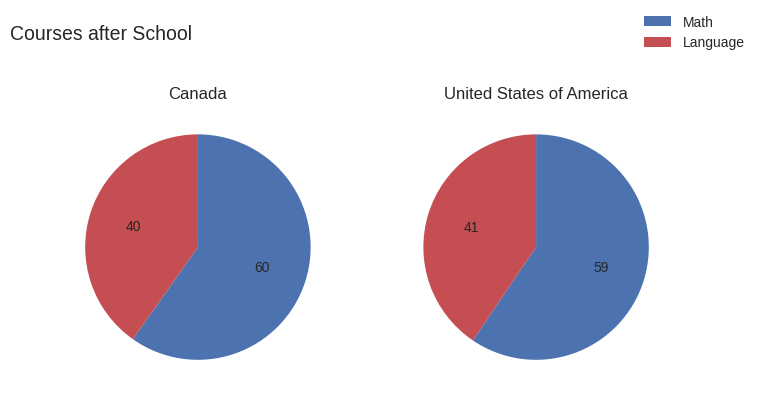

In [22]:
pie_fig(df_ca.ST48Q01, df_us.ST48Q01, [blue, red], ['Math', 'Language'],
        'Courses after School')

/tmp/ipykernel_1972329/1569874537.py:14: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, bbox_to_anchor=(1, .94))


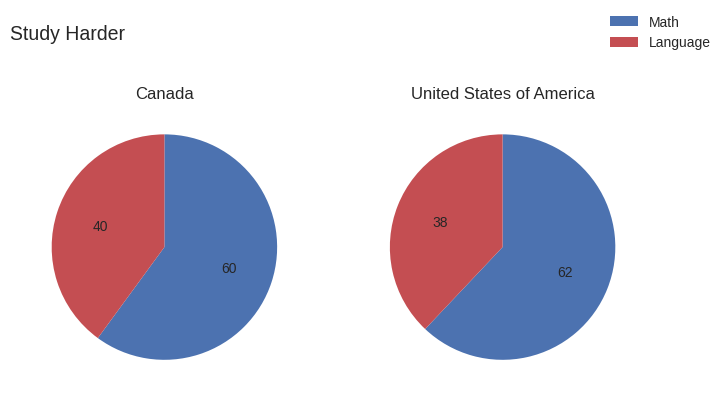

In [23]:
pie_fig(df_ca.ST48Q03, df_us.ST48Q03, [blue, red], ['Math', 'Language'],
        'Study Harder')

American students are not preoccupied with language arts. About 60% of them actually report studying longer and harder for math—or intending to do so—about the same as Canadian students.

#### Then are they preoccupied with science?

/tmp/ipykernel_1972329/1569874537.py:14: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, bbox_to_anchor=(1, .94))


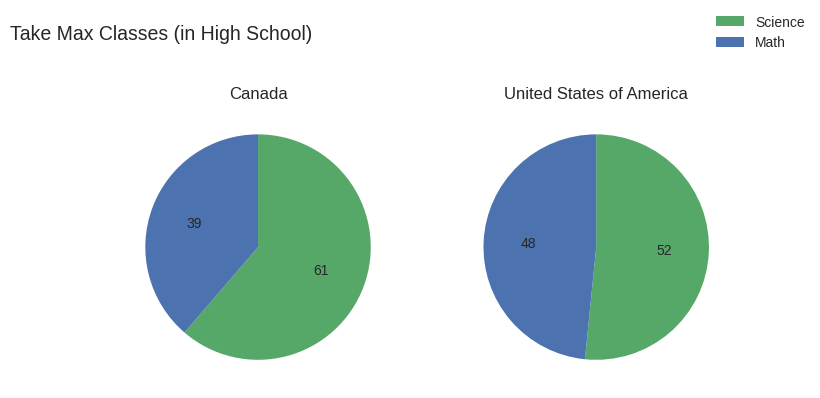

In [24]:
pie_fig(df_ca.ST48Q04, df_us.ST48Q04, [green, blue], ['Science', 'Math'],
        'Take Max Classes (in High School)')

Not really. While the majority of STEM-focused students—in both countries—emphasize science, the margin in the US is quite slim. In fact, the share of these students emphasizing math is *greater* in the US than in Canada—by nine points, no less!

/tmp/ipykernel_1972329/1569874537.py:14: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, bbox_to_anchor=(1, .94))


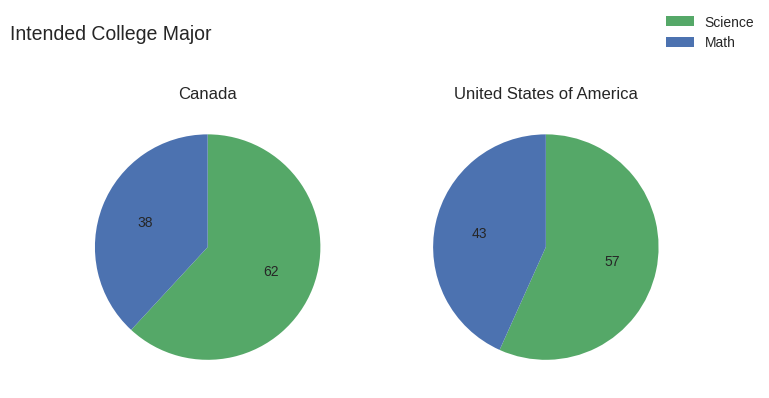

In [25]:
pie_fig(df_ca.ST48Q02, df_us.ST48Q02, [green, blue], ['Science', 'Math'],
        'Intended College Major')

/tmp/ipykernel_1972329/1569874537.py:14: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, bbox_to_anchor=(1, .94))


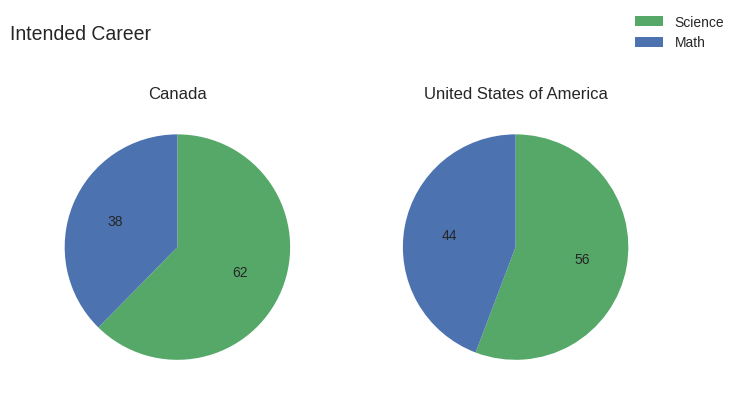

In [26]:
pie_fig(df_ca.ST48Q05, df_us.ST48Q05, [green, blue], ['Science', 'Math'],
        'Intended Career')

🚩 Among American students, there is a five point drop-off between high school and college. 48% of STEM-focused students maximize their number of math classes, but only 43% of them intend to major in a math-related field. 

Conversely, the class preferences of Canadian students are in line with their plans down the road. 39% of Canadian students take more math classes in high school. Likewise, 38% of Canadian students intend to major in a math-related field.

In [27]:
sns.set_style('white')

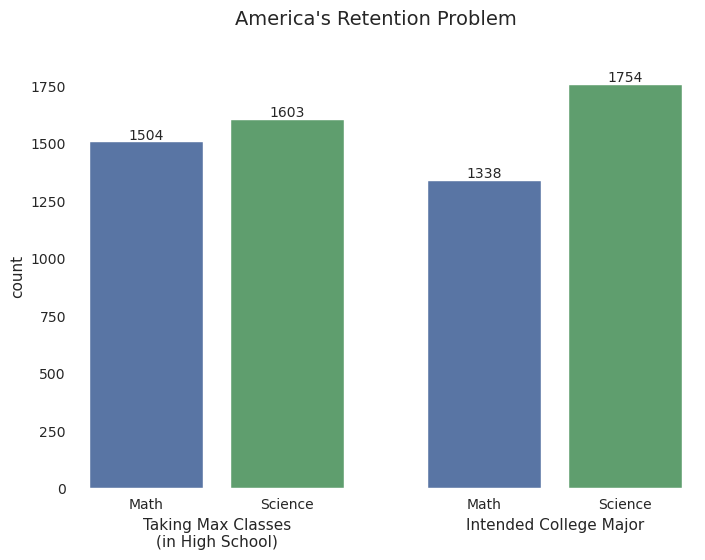

In [28]:
fig = plt.figure()
    
ax1 = fig.add_subplot(1, 2, 1)
g = sns.countplot(x=df_us.ST48Q04)
g.bar_label(g.containers[0])
g.set(xticklabels=['Math', 'Science'], xlabel='Taking Max Classes\n(in High School)')
ax2 = fig.add_subplot(1, 2, 2)
g = sns.countplot(x=df_us.ST48Q02)
g.bar_label(g.containers[0])
g.set(xticklabels=['Math', 'Science'], xlabel='Intended College Major')
ax1.set_ylim(ax2.get_ylim())
ax2.set_yticks([])
ax2.set_ylabel('')
fig.suptitle('America\'s Retention Problem', size=14);

In [29]:
df_us.shape[0]

4978

In the sample, there is a shortfall of 166 students, on the math side, going from high school to college. And the sample only includes 4978 students. This comes out to 3.3%, which may seem small, but across America, there are [77 million high school students](https://www.census.gov/newsroom/press-releases/2019/school-enrollment.html). Nationally, that amounts to a shortfall of *2.6 million* math-related majors. At least science sees a commensurate increase.

In [30]:
np.round(77000000*(166/4978)).astype(int)

2567698

## Univariate Exploration: Aggregate Scores

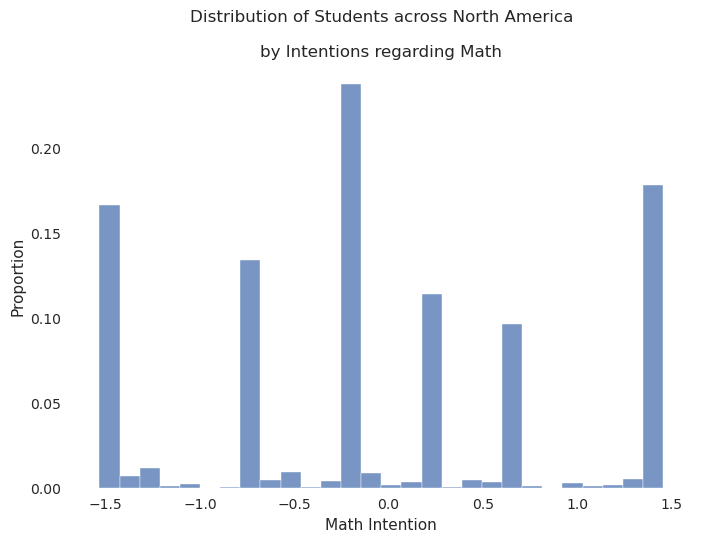

In [31]:
sns.histplot(df.MATINTFC, stat='proportion')
plt.xlabel('Math Intention')
plt.suptitle('    Distribution of Students across North America')
plt.title('by Intentions regarding Math');

In [32]:
print(f'Max:  {df.MATINTFC.max()}')
print(f'Min: {df.MATINTFC.min()}')

Max:  1.4565
Min: -1.5329


> 🔍 The `MATINTFC` column is a measure of a student's intentions towards math, namely whether they're oriented towards (+) or away from it (-). The score is based on their responses to the aforementioned five variables, each of which essentially ask, "Math or not math?" If a student always picks math, they get the highest score (`1.4565`). And if they never pick math, they get the lowest score(`-1.5329`). People who pick math once, twice, thrice, or four times get the peaks in between.

##### But what causes the stubby, little bins?

In [33]:
# looking into a stubby little bin
df[['MATINTFC', 'ST48Q01', 'ST48Q02', 'ST48Q03',
    'ST48Q04', 'ST48Q05']].query('MATINTFC > 1.0 and MATINTFC < 1.1').head(3)

,MATINTFC,ST48Q01,ST48Q02,ST48Q03,ST48Q04,ST48Q05
74870,1.0129,<NA>,Major in college Math,Study harder Math,<NA>,<NA>
75417,1.0129,<NA>,Major in college Math,Study harder Math,<NA>,<NA>
80251,1.0169,Courses after school Math,Major in college Math,<NA>,<NA>,<NA>


The stubby, little bins are caused by NaNs!

In [34]:
# dropping all the scores derived from any NaNs
df_intentions = df[['MATINTFC', 'ST48Q01', 'ST48Q02', 'ST48Q03', 'ST48Q04',
                    'ST48Q05']].dropna()

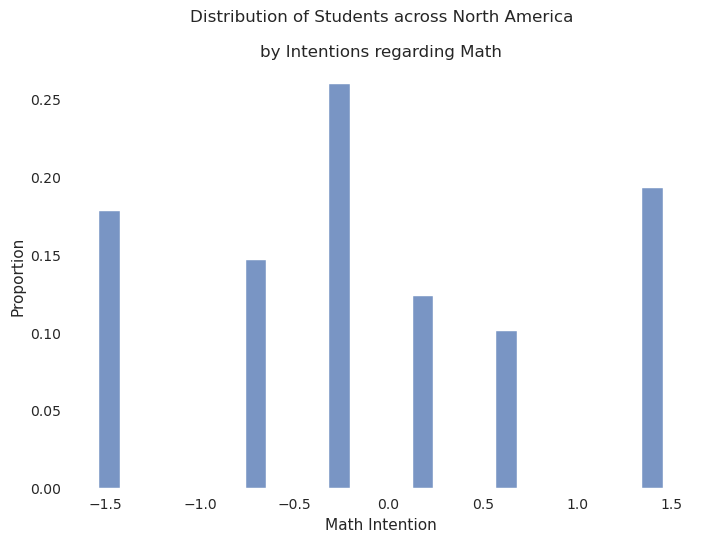

In [35]:
# replotting
sns.histplot(df_intentions.MATINTFC, stat='proportion')
plt.xlabel('Math Intention')
plt.suptitle('    Distribution of Students across North America')
plt.title('by Intentions regarding Math');

### So how does Math Intention break down by country?

In [36]:
def hist(ca_col, us_col, xlab):
    '''
    Plot two histplots to easily compare CA & US. Use the Freedman-Diaconis rule
    to calculate the number of bins.
    '''
    count, _, _, min_, q1, _, q3, max_ = ca_col.describe()
    bin_width = (2 * (q3 - q1)) / (count ** (1 / 3))
    bins_ca = int(np.ceil((max_ - min_) / bin_width))
    
    count, _, _, min_, q1, _, q3, max_ = us_col.describe()
    bin_width = (2 * (q3 - q1)) / (count ** (1 / 3))
    bins_us = int(np.ceil((max_ - min_) / bin_width))
    
    bins = np.mean([bins_ca, bins_us]).astype(int)
    
    fig = plt.figure()   

    ax1 = fig.add_subplot(1, 2, 1)
    sns.histplot(ca_col, stat='proportion', bins=bins)
    ax1.set_xlabel(xlab)
    plt.title('Canada')
    ax2 = fig.add_subplot(1, 2, 2)
    sns.histplot(us_col, stat='proportion', bins=bins)
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_xlabel(xlab)    
    plt.title('United States of America');

In [37]:
df_us_intentions = df_us[['MATINTFC', 'ST48Q01', 'ST48Q02', 'ST48Q03',
                          'ST48Q04', 'ST48Q05',]].dropna()
df_ca_intentions = df_ca[['MATINTFC', 'ST48Q01', 'ST48Q02', 'ST48Q03',
                          'ST48Q04', 'ST48Q05',]].dropna()

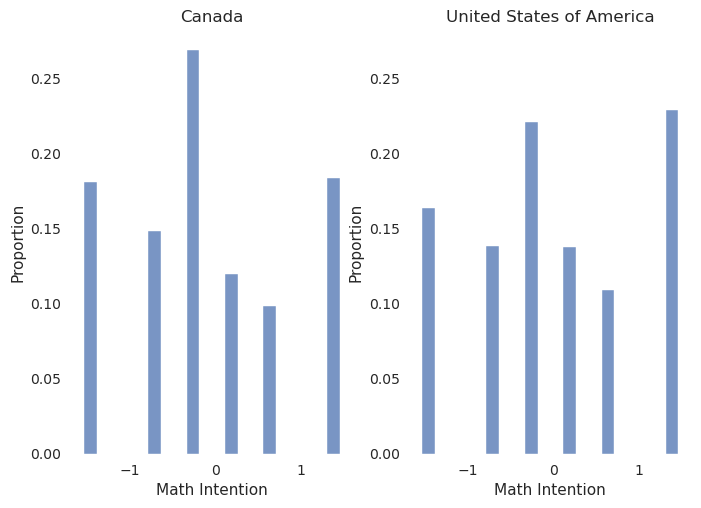

In [38]:
hist(df_ca_intentions.MATINTFC, df_us_intentions.MATINTFC, 'Math Intention')

Both distributions are multimodal, but there is a crucial difference. The highest peak for Canada is in the middle—about where you might expect it—whereas the highest peak for the United States is at the upper bound.

The average American student may be less math-focused than the average Canadian student, but a greater proportion of American students are *fully* focused on math (23% vs 18%).

### What about the affective factors?

> Affective *adj*<br>
Of or pertaining to emotions, feelings, or moods.

#### Subjective Norms?

In [39]:
df_us_norms = df_us[['SUBNORM', 'ST35Q01', 'ST35Q02', 'ST35Q03', 'ST35Q04', 
                     'ST35Q05', 'ST35Q06',]].dropna()
df_ca_norms = df_ca[['SUBNORM', 'ST35Q01', 'ST35Q02', 'ST35Q03', 'ST35Q04', 
                     'ST35Q05', 'ST35Q06',]].dropna()

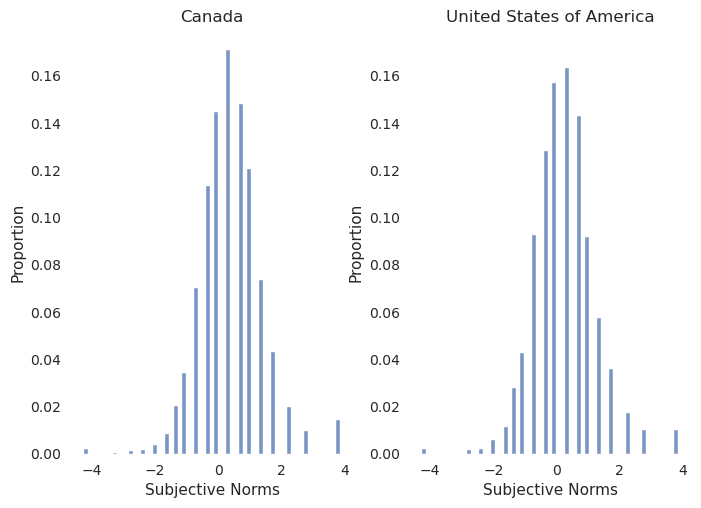

In [40]:
hist(df_ca_norms.SUBNORM, df_us_norms.SUBNORM, 'Subjective Norms')

In [41]:
df.ST35Q01.unique()

array([<NA>, 'Agree', 'Strongly agree', 'Disagree', 'Strongly disagree'],
      dtype=object)

The `SUBNORM` feature is based on six questions about friends and family, specifically whether they're oriented towards math. The questions have four possible answers: 1) strongly disagree, 2) disagree, 3) agree, and 4) strongly agree.

It is normally distributed with a mode of zero. Thus, in both countries, most students come from home-life cultures that are largely ambivalent towards math. It falls upon the teachers to encourage them towards the topic.

#### Perceived Behavioral Control?

In [42]:
df_ca_eff = df_ca[['MATHEFF', 'ST37Q01', 'ST37Q02', 'ST37Q03', 'ST37Q04', 'ST37Q05',
                   'ST37Q06', 'ST37Q07', 'ST37Q08',]].dropna()
df_us_eff = df_us[['MATHEFF', 'ST37Q01', 'ST37Q02', 'ST37Q03', 'ST37Q04', 'ST37Q05',
                   'ST37Q06', 'ST37Q07', 'ST37Q08',]].dropna()

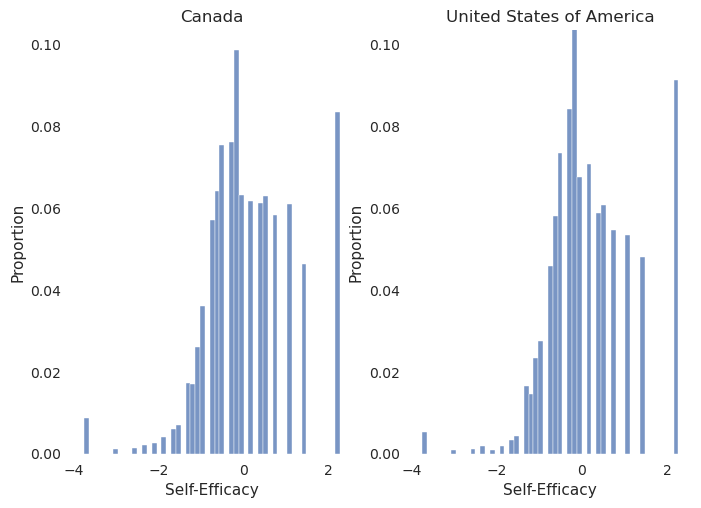

In [43]:
hist(df_ca_eff.MATHEFF, df_us_eff.MATHEFF, 'Self-Efficacy')

In [44]:
df.ST37Q01.unique()

array([<NA>, 'Not very confident', 'Confident', 'Not at all confident',
       'Very confident'], dtype=object)

The `MATHEFF` feature comprises eight questions, which ask students how confident they are performing practical math tasks like calculating petrol (gasoline) consumption rate or square meters of tiles. There are four confidence levels: not at all confident (-4), not very confident (-2), confident (0), and very confident (+2).

These histograms skew left, but that's by design. There is no +4, "totally confident" category to balance out the "not at all confident" category. "Confident" is the baseline. In both countries, most students are largely confident, more or less. There is a second peak of fully confident students, which is higher in the US—reminiscent of the Math Intention histogram (above).

#### What about Attitude?

In [45]:
df_us_concept = df_us[['SCMAT', 'ST42Q02', 'ST42Q04', 'ST42Q06', 'ST42Q07', 
                       'ST42Q09',]].dropna()
df_ca_concept = df_ca[['SCMAT', 'ST42Q02', 'ST42Q04', 'ST42Q06', 'ST42Q07', 
                       'ST42Q09',]].dropna()

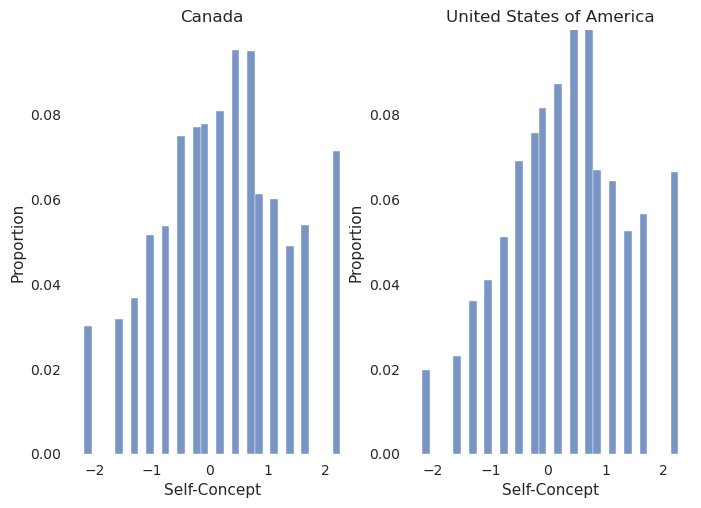

In [46]:
hist(df_ca_concept.SCMAT, df_us_concept.SCMAT, 'Self-Concept')

In [47]:
df.ST42Q02.unique()

array(['Disagree', 'Agree', <NA>, 'Strongly disagree', 'Strongly agree'],
      dtype=object)

The `SCMAT` feature is based on five questions assessing whether students have positive or negative feelings about studying math. There are four levels of agreement: 1) strongly disagree, 2) disagree, 3) agree, and 4) strongly agree.

While most students are largely ambivalent towards their math studies, some have strong positive feelings. Another positive: relatively few students harbor strongly negative feelings towards mathematics, especially in the US.

Regarding the affective factors, Canada and the United States are largely the same—at least at this aggregate level of analysis. 

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The distribution of our main feature—Intention (`MATINTFC`)—is bimodal in much the same way as the Self-Efficacy (`MATHEFF`) and Self-Concept (`SCMAT`) histograms.

> This would support the theory of planned behavior *assuming* it's the same students in the right-most bin each time. But this is a dangerous assumption to make—and an unnecessary one. We need not assume anything: We need only analyze the relationships between these variables.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Two types of changes were made to the dataset since it was read in. First, it was split between American and Canadian students to facilitate comparisons (`df_us` & `df_ca`). Then, slices of them were copied and purged of NaNs to produce the neat histograms above without needlessly dropping rows from the main data frames.

## Bivariate Exploration

We will be focusing on the US from now on because in terms of these aggregated variables, Canada and the United States are basically the same. The US is our main area of interest anyway. As an added bonus, this will help prevent overplotting in our scatter plots.

### What is the precise relationship between Intentions and each of the affective variables?

In [48]:
agg_dict = {
    'Math Intentions':df_us_intentions.MATINTFC,
    'Subjective Norms':df_us_norms.SUBNORM,
    'Self-Efficacy':df_us_eff.MATHEFF,
    'Self-Concept':df_us_concept.SCMAT,
}

In [49]:
df_us_inec_agg = pd.DataFrame(agg_dict).dropna()
df_us_inec_agg.head()

,Math Intentions,Subjective Norms,Self-Efficacy,Self-Concept
475554,-0.2514,0.6602,-0.48,-0.29
475557,1.4565,0.6602,-0.48,0.41
475558,0.1775,0.6602,-0.18,0.41
475568,-0.7332,1.4014,0.15,0.65
475569,1.4565,-0.0455,0.54,1.70


In [50]:
def reg(xcol, ycol, jit):
    '''Plot a regplot without overplotting.'''
    sns.regplot(data=df_us_inec_agg,
        x=xcol,
        y=ycol,
        scatter_kws={'alpha':1/10},
        x_jitter=jit,
        y_jitter=jit,
    );

#### Intentions vs. Subjective Norms?

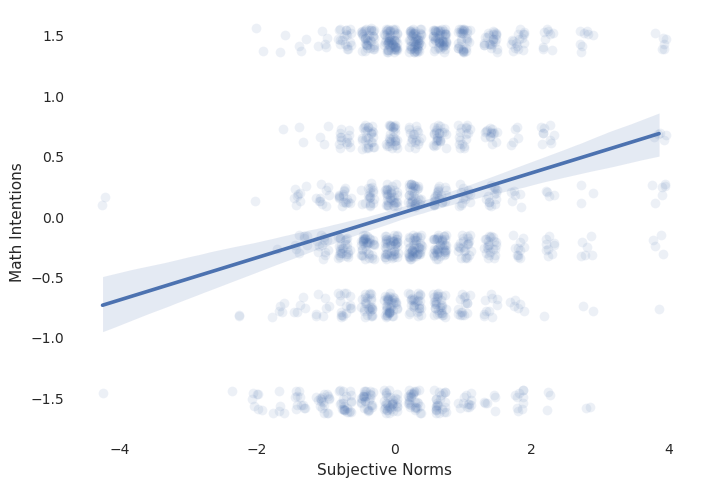

In [51]:
reg('Subjective Norms', 'Math Intentions', 0.1)

Most of the plot points are at the center: most students are not particularly encouraged or discouraged to do math by friends & family. Some of them go towards math, and others away from it. 

Interestingly, students who are especially encouraged (+4) tend to be math-oriented, albeit moderately. The sample size is very small here, but the trendline corroborates this conclusion.

#### Intentions vs. Perceived Behavioral Control?

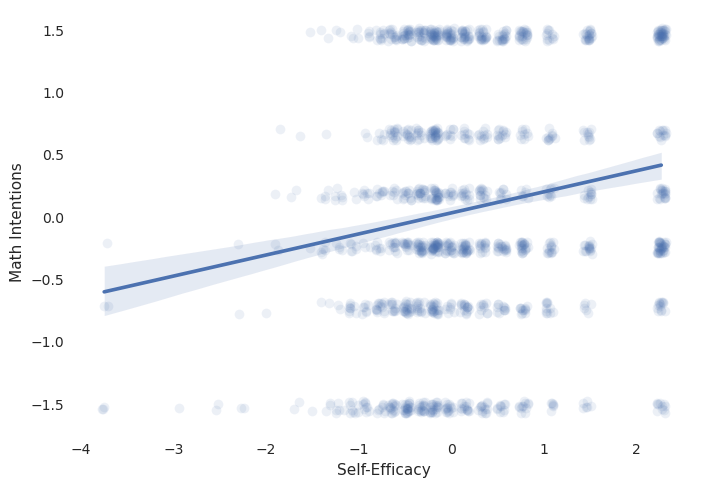

In [52]:
reg('Self-Efficacy', 'Math Intentions', 0.05)

This graph looks a lot like the last one. One crucial difference is the plots points in the lower right-corner. These students are confident in their math skills yet very much not oriented towards math.

#### Intentions vs. Attitude?

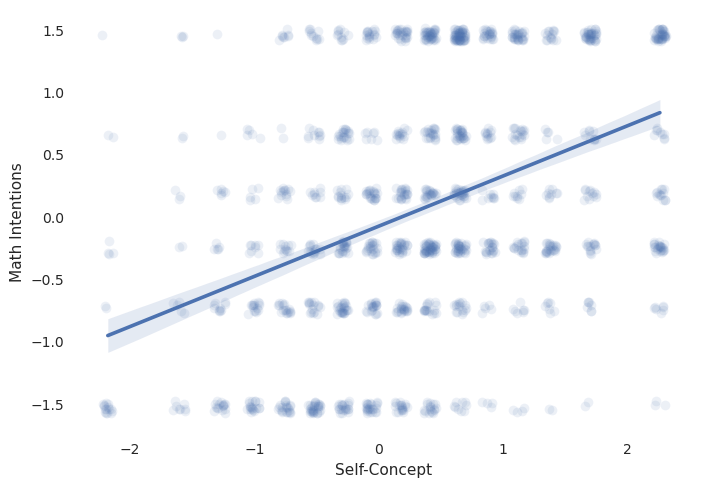

In [53]:
reg('Self-Concept', 'Math Intentions', 0.05)

Now in *this* plot, most of the points are clearly in the top-right and bottom-left quadrants. This relationship is considerably stronger than the previous ones—though still on the weaker side in general. While there are a lot of outliers, that is to be expected given the *tri*modal distribution of Math Intentions.

### What are the relationships between the affective variables?

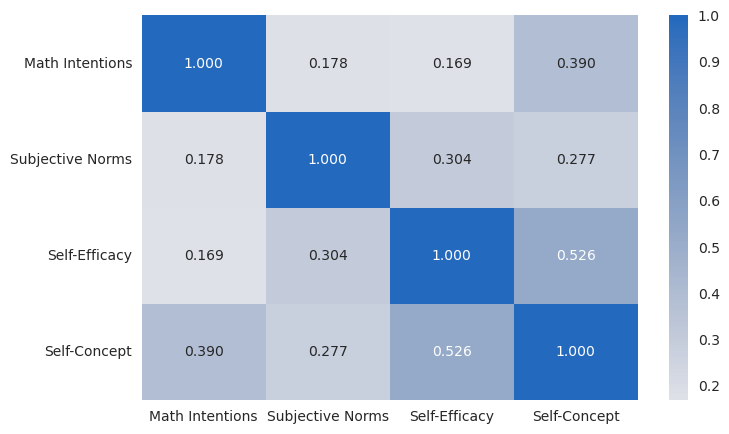

In [54]:
plt.figure(figsize = [8, 5])

sns.heatmap(df_us_inec_agg.corr(), annot=True, fmt='.3f', cmap='vlag_r',
    center=0);

All of these relationships are positively correlated, perhaps significantly so in some cases.

/home/e/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


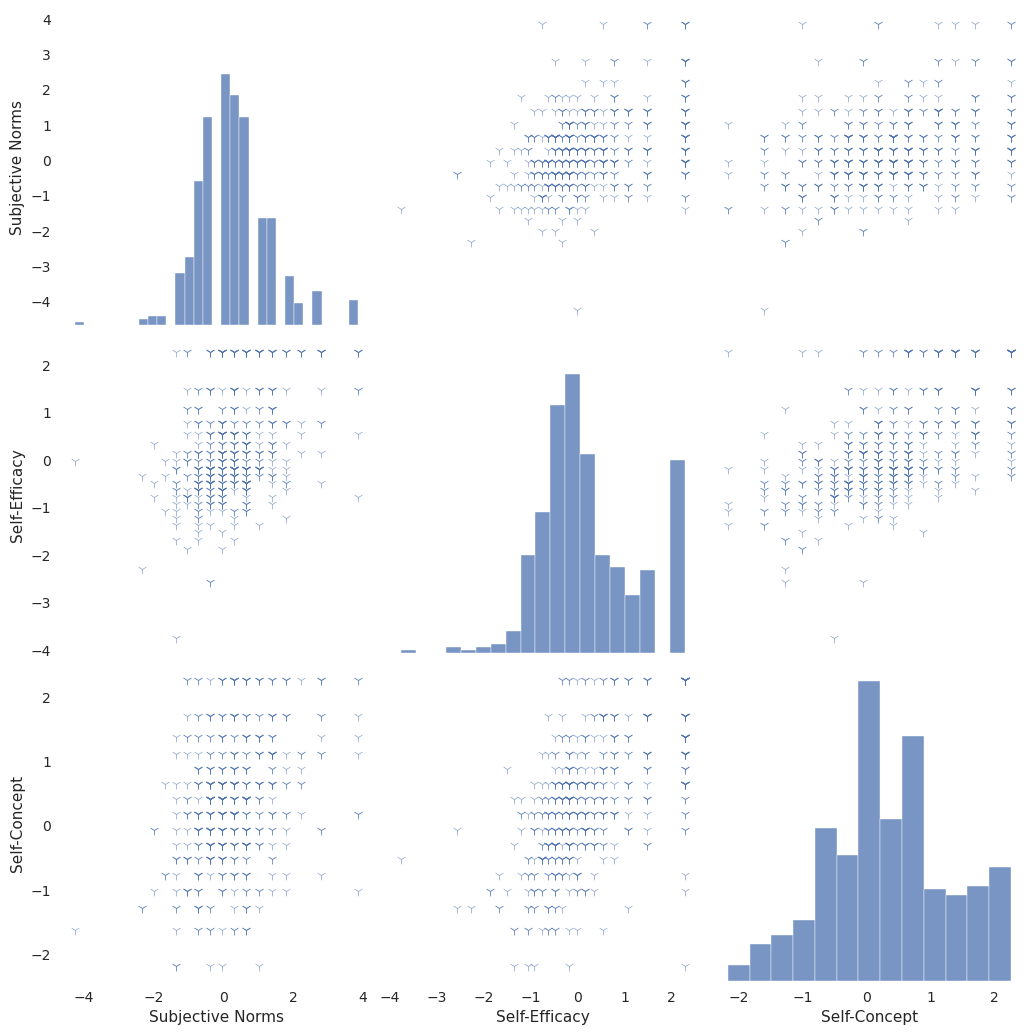

In [55]:
# Ensuring the relationships are linear—and observing the outliers
df_us_inec_agg_samp = df_us_inec_agg[['Subjective Norms', 'Self-Efficacy', 'Self-Concept']].sample(500)
sns.pairplot(data=df_us_inec_agg_samp, vars=['Subjective Norms', 'Self-Efficacy', 'Self-Concept'],
             markers='1', height=3.5, plot_kws={'alpha':3/5});

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

The feature of interest—Math Intention—has a correlation coefficient of 0.390 with Self-Concept. By social science standards, that could be considered moderate.

> As a rule, social sciences tend more towards description than prediction, so high coefficients aren't required. Moreover, social systems are complex and messy, so lower coefficients are to be expected. Whether or not it's high *enough* depends on the specific use-case and context.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

Self-Concept is also moderately correlated (0.526) with Self-Efficacy. This makes sense, as people tend to like doing what they're good at.

## Multivariate Exploration

The weakest correlation in the heat map is between Self-Efficacy and Math Intention, our feature of interest. Self-Efficacy is our proxy for perceived behavioral control, the feature component of the theory of planned behavior (TPB). Interestingly, the TPB was born when this [feature was tacked on](https://www.sciencedirect.com/topics/medicine-and-dentistry/theory-of-planned-behavior) to its predecessor, the theory of reasoned action (TRA). This was done to improve the predictive power of the theory—it's also used in things like advertising. Since our goals here are descriptive, the more streamlined TRA might better serve our purposes.

#### <strong>Theory of reasoned action</strong>

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f9/Theory_of_reasoned_action.png" alt="Diagram showing simple causal chain from subjective norms through intentions on to behavior" width="640" height="380">

<span style="font-size:80%;">“Theory of reasoned action”, by Stevienicks22, licensed under <a href="https://creativecommons.org/licenses/by-sa/4.0/deed.en">CC BY 4.0</a></span>

### Does the theory of reasoned action (TRA) suffice to explain Math Intentions?

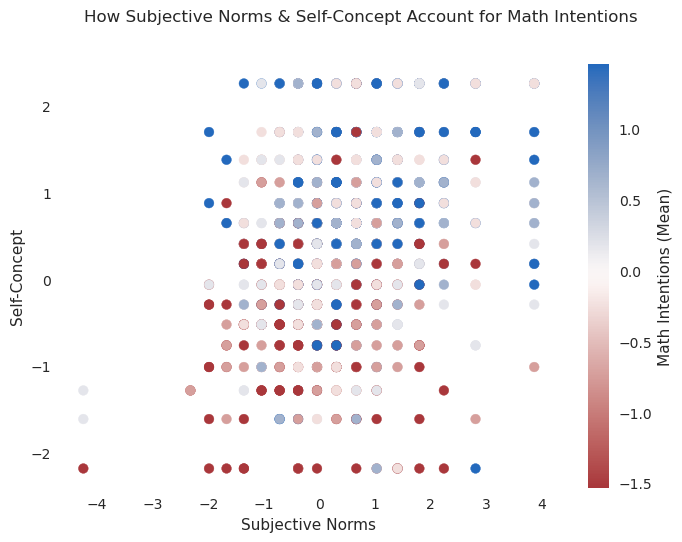

In [56]:
plt.scatter(data=df_us_inec_agg, x='Subjective Norms', y='Self-Concept', c='Math Intentions', cmap='vlag_r')
plt.xlabel('Subjective Norms')
plt.ylabel('Self-Concept')
plt.suptitle('How Subjective Norms & Self-Concept Account for Math Intentions')
plt.colorbar(label='Math Intentions (Mean)');

The plot clearly shows how Self-Concept and Subjective Norms relate positively to Math Intention. The plot points in the upper-right quadrant tend to be blue—and those in the lower-left tend to be red. Also, note how the top half is bluer than the right half, which further demonstrates that Self-Concept affects Math Intention more.

### But is Self-Concept affected by Subjective Norms as it relates to Math Intention?

Is there a direct link between the two, as suggested by the aforementioned theory of planned behavior—and crucially, *not* by the theory currently under consideration?

Self-Concept & Subjective Norms have a correlation coefficient of 0.277, just high enough to warrant further scrutiny—again, by social science standards.

The question is, does the Subjective Norms variable *moderate* the relationship between Self-Concept and Math Intentions?

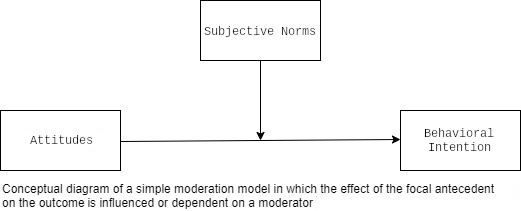

In [57]:
display.Image("./Simple_moderation_model_conceptual_diagram_relabeled.jpg")

<span style="font-size:80%;">"<a href="https://upload.wikimedia.org/wikipedia/commons/d/d6/Simple_moderation_model_conceptual_diagram.jpg">Simple moderation model conceptual diagram</a>", by Rjl503, licensed under <a href="https://creativecommons.org/licenses/by-sa/4.0/deed.en">CC BY 4.0</a> / Relabeled</span>

In [58]:
# One approach is to facet the data across the hypothetical moderator to see if
# the relationship between the plotted variables is affected.
sn_cat_list = [
    'Very Discouraging',
    'Discouraging',
    'Neutral',
    'Encouraging',
    'Very Encouraging',
]

In [59]:
sn_cat_S = pd.cut(df_us_inec_agg['Subjective Norms'], 5, labels=sn_cat_list)

df_us_inec_agg.insert(1, 'Subjective Norms - Category', sn_cat_S)

/home/e/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/e/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/e/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


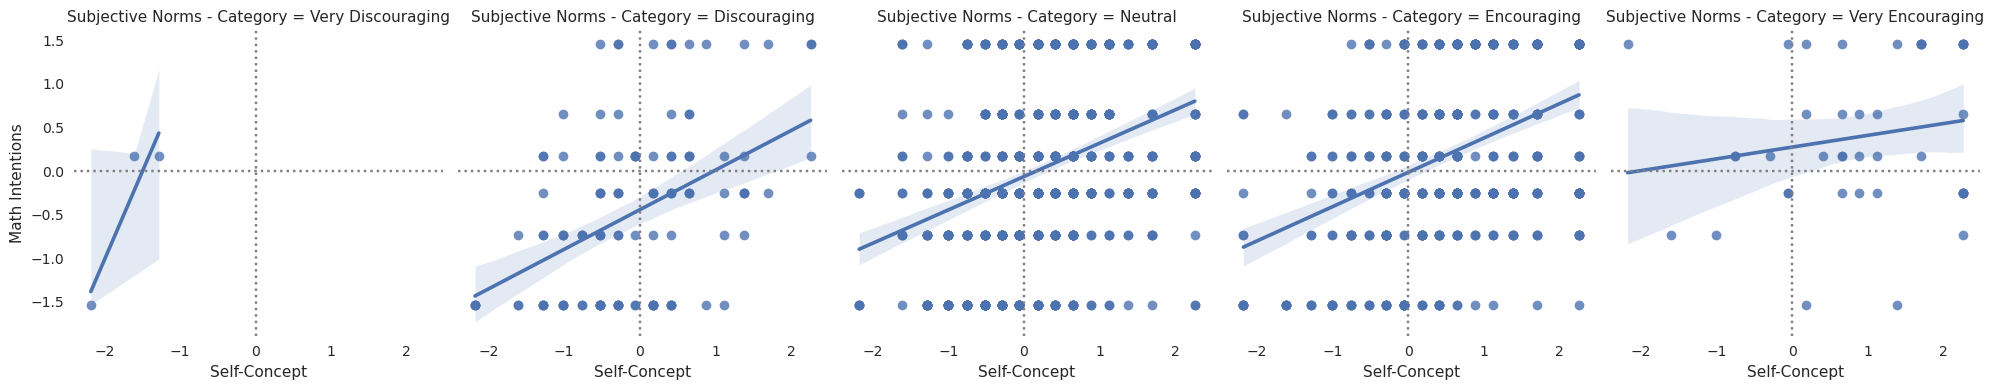

In [60]:
g = sns.FacetGrid(data=df_us_inec_agg, col='Subjective Norms - Category', height=4)
g.map(sns.regplot, 'Self-Concept', 'Math Intentions');
g.map(plt.axhline, y=0, ls=':', c='grey')
g.map(plt.axvline, x=0, ls=':', c='grey');

At first glance, it appears as though the Self-Concept/Math Intentions relationship is affected by Subjective Norms—at least at the extremes of 'Very Discouraging' and 'Very Encouraging'. However, there aren't enough plot points there to tell, and as such, the confidence intervals are simply too wide to be useful.

> Had this been a statistical experiment, we would say, "We fail to reject the null hypothesis that the relationship between Self-Concept and Math Intentions is not moderated by Subjective Norms."

On the other hand, the facet grid shows no real difference in the Self-Concept/Math Intention relationship whether the norms are 'Encouraging,' 'Neutral,' or 'Discouraging.'

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

This section focused on the affective variables most strongly correlated with our variable of interest. Yes, taken together, Subjective Norms & Self-Concept *are* able to account for Math Intentions. 

### Were there any interesting or surprising interactions between features?

There does not appear to have been any interactions between the affective features, as expected, since Self-Efficacy was discarded to streamline our theoretical model.

## Conclusions

### Summary of Main Findings

The theory of reasoned action (TRA) adequately explains why some American students intend to do math, and others do not. While a number of variables may be involved, one affect particularly stands out: attitude, or the way a person feels about some behavior—in this context, doing math.* It has a pronounced effect on a student's intention to do math, relative to the other affects. Sure, it's only moderately correlated to math intention, but that's why the TRA has another feature. This feature, subjective norms, refers to perceptions of how one's friends and family feel about the behavior in question. Students strongly encouraged to do math tend to want to do so. By itself, the effect is slight, but combined with attitude/self-concept, it's enough to obviate the need for any other explanatory variables like self-efficacy—which is somewhat redundant with self-concept anyway.

*PISA calls it Self-Concept. For them, it entails things feeling it's one of your best subjects (`ST42Q07`) and feeling like you learn it quickly (`ST42Q06`).
    
The simpler, the better. Complex theories may aid the researcher or analyst with understanding, but they seldom persuade the policy maker, who is too busy running things to study them deeply. Here in the US, our education policy needs reforming. America needs more math-savvy people, but the school systems are failing to produce them. And it's not the students' fault. American STEM students prioritize math over science at a rate greater than that of their Canadian counterparts, and fewer American kids have low, math self-concept. Yet Canada excels.

They don't have our retention problem. 10% of math-oriented, high-school students have no intention of going to college for math—or of pursuing a career in it. That amounts to millions of students nationwide.

The theory of reasoned action suggests a solution: the total overhaul of our culture as it pertains to math. For starters, we need to normalize it—not stigmatize it. Parents need to encourage their kids to do math, and kids need to encourage each other. Then we need to shift the prevailing attitudes toward it. Government and private enterprise need to do more to promote and invest in mathematics. People ought to know how in-demand and lucrative it can be. Hollywood needs to make geeks chic and nerds sexy. When I was a kid, we had Star Trek. These days, well, kids still have Star Trek, only with less STEM and even more phasers. But most of all, we need to make doing math more accessible, in every sense of the word. Given ample opportunity, our students can also succeed at math. We just have to set them up for it.

### Steps Taken

0. Studied the data dictionary; reviewed relevant theoretical models.
1. Charted each variable in the key feature group to better understand it.
2. Looked at the aggregate score for the feature group.
   1. Looked at the aggregate score for related groups.
   2. Cleaned up the data as needed.
3. Investigated the relationships between the feature and the other variables.
4. Honed in on a theoretical, explanatory model.
5. Conducted an informal, hypothesis "eye" test to see if it checks out.